## Access Mooring Acidification Delayed QC (Parquet)
This Jupyter notebook demonstrates how to access and plot mooring_acidification_delayed_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/89b495cc-7382-43c0-abef-d1e66738a924).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/mooring_acidification_delayed_qc.ipynb).


In [1]:
dataset_name = "mooring_acidification_delayed_qc"

## Install/Update packages and Load common functions

In [ ]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

In [2]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 36.3 ms, sys: 9.56 ms, total: 45.9 ms
Wall time: 8.61 s


In [4]:
aodn_dataset.dataset.partitioning.schema

site_code: string
timestamp: int32
polygon: string

## List unique partition values

In [5]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_code')
print(list(unique_partition_value))  # showing a subset only

['NRSYON', 'NRSKAI', 'GBRWIS', 'NRSMAI']
CPU times: user 1.41 ms, sys: 164 µs, total: 1.57 ms
Wall time: 1.25 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


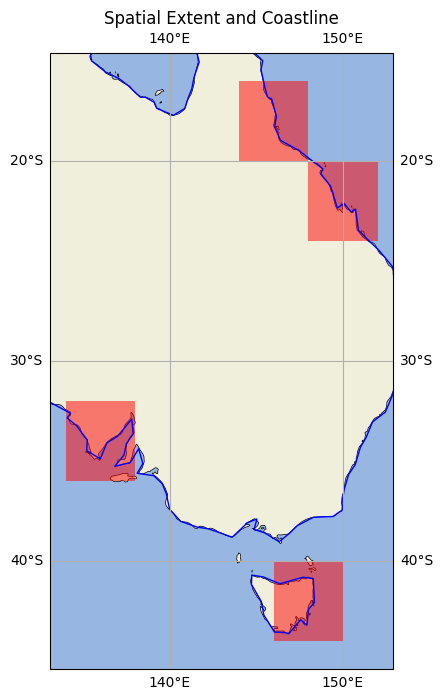

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
%%time
aodn_dataset.get_temporal_extent()

CPU times: user 59.1 ms, sys: 140 ms, total: 199 ms
Wall time: 407 ms


(Timestamp('2009-10-09 06:00:00'), Timestamp('2025-05-26 06:00:00'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-10-29 12:56:47,911 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_acidification_delayed_qc.parquet


{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'analysis_time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 999999.0,
  'ancillary_variables': 'TIME_quality_control'},
 'TEMP': {'type': 'double',
  'standard_name': 'sea_surface_temperature',
  'long_name': 'sea_surface_temperature',
  'units': 'Celsius',
  'valid_min': -2.0,
  'valid_max': 40.0,
  'sensor_serial_number': '5551',
  'sensor': 'SBE 16Plus V2 SeaCAT',
  'ancillary_variables': 'TEMP_quality_control'},
 'PSAL': {'type': 'double',
  'standard_name': 'sea_surface_salinity',
  'long_name': 'sea surface salinity',
  'units': '1e-3',
  'valid_min': 0.0,
  'valid_max': 42.0,
  'sensor_serial_number': '5551',
  'sensor': 'SBE 16Plus V2 SeaCAT',
  'ancillary_variables': 'PSAL_quality_control'},
 'Press_ATM': {'type': 'double',
  'standard_name': 'air_pressure_at_sea_level',
  'long_name': 'barometric pressure at sea level',
  'units': 'kPa',
  'valid_min': 50.0,
  'valid_max': 150.0,
  'ancillary_

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [9]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-01', 
                           date_end='2024-01-01',
                           lat_min=-45, 
                           lat_max=-40, 
                           lon_min=140, 
                           lon_max=155, 
                           )

df.info()

2025-10-29 12:56:48,583 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_acidification_delayed_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   TIME                         6844 non-null   datetime64[ns]
 1   TEMP                         6842 non-null   float64       
 2   PSAL                         6842 non-null   float64       
 3   Press_ATM                    6844 non-null   float64       
 4   xCO2EQ_PPM                   6837 non-null   float64       
 5   xCO2ATM_PPM                  6837 non-null   float64       
 6   fCO2SW_UATM                  6835 non-null   float64       
 7   DfCO2                        6835 non-null   float64       
 8   SUBFLAG                      6844 non-null   float64       
 9   LATITUDE                     6844 non-null   float64       
 10  LONGITUDE                    6844 non-null   float64       
 11  DOX1                         6844 non-null 

In [10]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_89b495cc-7382-43c0-abef-d1e66738a924_mooring_acidification_delayed_qc_data-hash_2358acf2.csv.zip

## Create a TIME and scalar/number filter

This cell filters the dataset by time range and a scalar value (from a Parquet partition) using the `scalar_filter` argument.  
This leverages Parquet partitioning to apply efficient, server-side filtering, which significantly speeds up data loading.

In [11]:
%%time
df = aodn_dataset.get_data(date_start='2021-01-01', 
                           date_end='2023-01-01',
                           scalar_filter={'site_code': "NRSMAI"})
df.info()

2025-10-29 12:56:49,467 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_acidification_delayed_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8755 entries, 0 to 8754
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   TIME                         8755 non-null   datetime64[ns]
 1   TEMP                         8755 non-null   float64       
 2   PSAL                         8755 non-null   float64       
 3   Press_ATM                    8755 non-null   float64       
 4   xCO2EQ_PPM                   8748 non-null   float64       
 5   xCO2ATM_PPM                  8748 non-null   float64       
 6   fCO2SW_UATM                  8748 non-null   float64       
 7   DfCO2                        8748 non-null   float64       
 8   SUBFLAG                      8755 non-null   float64       
 9   LATITUDE                     8755 non-null   float64       
 10  LONGITUDE                    8755 non-null   float64       
 11  DOX1                         8755 non-null 

<Axes: title={'center': 'IMOS - National Mooring Network - Acidification Moorings (AM) Sub-Facility - delayed mode data'}, xlabel='TIME', ylabel='sea_surface_temperature in Celsius'>

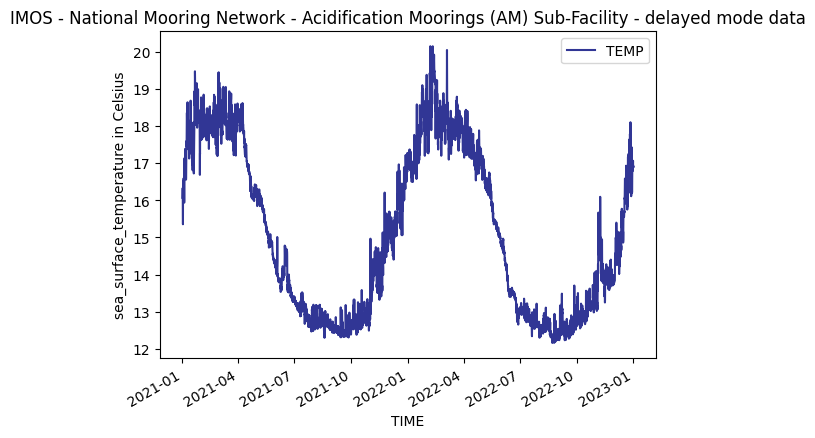

In [12]:
df[df['TEMP_quality_control'] == 2].sort_values('TIME').plot(y='TEMP', x='TIME', cmap='RdYlBu_r',
                                                             ylabel=f"{metadata['TEMP']['standard_name']} in {metadata['TEMP']['units']}" ,
                                                             title=metadata['global_attributes']['title']
                                                                     )